10
Forward search started at: 2024-05-15 20:47:56.276486
Forward search ended at: 2024-05-15 20:47:56.279199
Duration: 0:00:00.002683
Backwards search started at: 2024-05-15 20:47:56.279506
Backwards search ended at: 2024-05-15 20:47:56.281914
Duration: 0:00:00.002391
Search started at: 2024-05-15 20:47:56.281979
Search ended at: 2024-05-15 20:47:56.282230
155693056
Total execution time: 0.5848891735076904 seconds
Results: {'10000000000000000001': 1024}


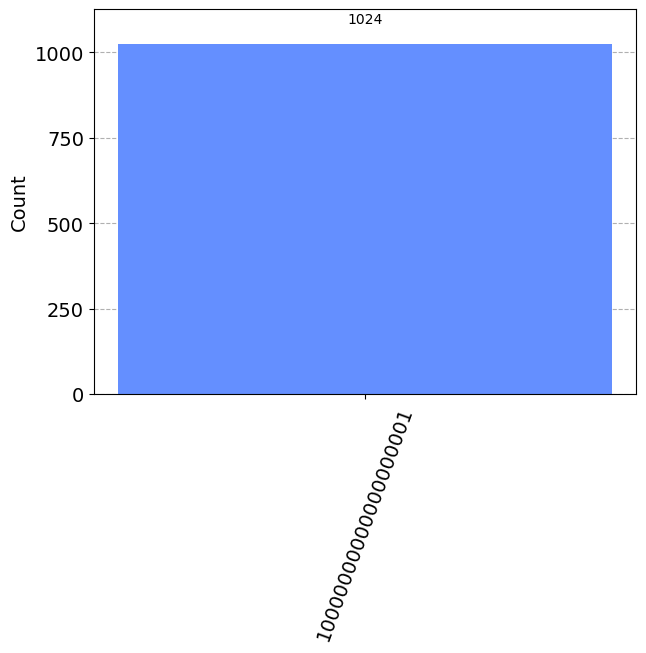

In [101]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import time
import threading
from qiskit.visualization import plot_histogram
from datetime import datetime
from multiprocessing import Pool
import psutil

# Define the necessary functions for the Grover search
def partial_hadamard_transform(circuit, qubits_to_superpose):
    for qubit in qubits_to_superpose:
        circuit.h(qubit)

def partial_oracle(circuit, qubits, ancilla, target_state):
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)
    circuit.mcx(qubits, ancilla)
    for qubit, bit in zip(qubits, target_state):
        if bit == '0':
            circuit.x(qubit)         

def partial_diffuser(circuit, qubits_pair):
    for qubit in qubits_pair:
        circuit.h(qubit)
        circuit.x(qubit)
    circuit.h(qubits_pair[-1])
    circuit.mcx(qubits_pair[:-1], qubits_pair[-1])
    circuit.h(qubits_pair[-1])
    for qubit in qubits_pair:
        circuit.x(qubit)
        circuit.h(qubit)

def apply_grover_to_segment_forward(circuit, start_qubit, mid_qubit, solution, ancilla, n):
    print(f"Forward search started at: {datetime.now()}")
    time1 = datetime.now()
    
    if (n / 2) % 2 == 1:
        circuit.h(start_qubit)
        if solution[start_qubit] == '1':
            circuit.z(start_qubit)
        circuit.h(start_qubit)
        start_qubit = start_qubit + 1
    
    # Process pairs of qubits up to the second last qubit
    for step in range(start_qubit, mid_qubit - 1, 2):
        qubits_to_superpose = list(range(step, min(step + 2, mid_qubit)))
        partial_hadamard_transform(circuit, qubits_to_superpose)
        partial_oracle(circuit, qubits_to_superpose, ancilla, solution[step:step+2])
        partial_diffuser(circuit, qubits_to_superpose)

    time2 = datetime.now()
    print(f"Forward search ended at: {datetime.now()}")
    print(f"Duration: {time2 - time1}")

def apply_grover_to_segment_backward(circuit, mid_qubit, end_qubit, solution, ancilla2, n):
    print(f"Backwards search started at: {datetime.now()}")
    time1 = datetime.now()

    if n % 2 == 1 or (n / 2) % 2 == 1:
        circuit.h(end_qubit-1)
        if solution[end_qubit-1] == '1':
            circuit.z(end_qubit-1)
        circuit.h(end_qubit-1)
        end_qubit = end_qubit - 1
    
    # Process pairs of qubits, starting from the end towards the midpoint
    for step in range(end_qubit - 2, mid_qubit - 2, -2):
        qubits_to_superpose = list(range(step, step + 2))
        partial_hadamard_transform(circuit, qubits_to_superpose)
        partial_oracle(circuit, qubits_to_superpose, ancilla2, solution[step:step+2])
        partial_diffuser(circuit, qubits_to_superpose)

    # Handle the last qubit separately if the total number of qubits is odd
    
    time2 = datetime.now()
    print(f"Backwards search ended at: {datetime.now()}")
    print(f"Duration: {time2 - time1}")
    
        
def run_concurrent_grover_search():
    n = 20
    circuit = QuantumCircuit(n + 2, n)  
    solution = '10000000000000000001'  # Example solution
    ancilla = n
    ancilla2 = n + 1
    circuit.x(ancilla)
    circuit.h(ancilla)
    circuit.x(ancilla2)
    circuit.h(ancilla2)
    mid_qubit = n // 2 if n % 2 == 0 else (n // 2) + 1
    
    
    print(mid_qubit)

    
    # Start threads for parallel-like execution
    thread_first_half = threading.Thread(target=apply_grover_to_segment_forward, args=(circuit, 0, mid_qubit, solution, ancilla, n))
    thread_second_half = threading.Thread(target=apply_grover_to_segment_backward, args=(circuit, mid_qubit, n, solution, ancilla2, n))

    thread_first_half.start()
    thread_second_half.start()

    thread_first_half.join()
    thread_second_half.join()
   
    #print(f"Search started at: {datetime.now()}"a)
    #apply_grover_to_segment_forward(circuit, 0, mid_qubit, solution, ancilla)
    #apply_grover_to_segment_backward(circuit, mid_qubit, n, solution, ancilla)
    
    # Measure all qubits at the end
    
    print(f"Search started at: {datetime.now()}")
    circuit.measure(range(n), range(n))
    
    
    print(f"Search ended at: {datetime.now()}")

    # Run the circuit
    backend = Aer.get_backend('aer_simulator')
    transpiled_circuit = transpile(circuit, backend)
    result = execute(transpiled_circuit, backend).result()
    counts = result.get_counts()
    #print(circuit)

    return counts

# Run the concurrent Grover search
start_time = time.time()
counts = run_concurrent_grover_search()
end_time = time.time()

process = psutil.Process()
print(process.memory_info().rss)

print(f"Total execution time: {end_time - start_time} seconds")
print(f"Results: {counts}")
plot_histogram(counts) 